In [ ]:
colors = [
    '#E69F00',  
    '#56B4E9',  
    '#009E73',  
    '#F0E442',
    '#D55E00', 
    '#CC79A7', 
    '#7D0CFF',  
    '#D80036',  
    '#1A5309',  
    '#A73FC7', 
    '#DF6535',  
    '#8ADD91',  
    '#1E90FF',  
    '#FF69B4',  
    '#444444'   
]

In [197]:
import pandas as pd
df = pd.read_csv('../data/preprocessed_df.csv')

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)  
df.head(3)

,female,gender_not_specified,male,not_cis,asexual,bi/pan/demi_sexual/queer,heterosexual,homosexual,income,romantic_relationship_intent,education_level_grouped,location_density,air_zodiac_sign,earth_zodiac_sign,fire_zodiac_sign,water_zodiac_sign,age,bio_length,likes_received,emoji_usage_rate,message_sent_count,interest_lifestyle,interest_health,interest_creativity,interest_education_culture,interest_entertainment,interest_social
0,0,1,0,0,0,0,0,1,2,0,1,2,0,1,0,0,56,44,173,0.36,75,0.333333,0.333333,0.000000,0.333333,0.000000,0.0
1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,40,301,107,0.42,35,0.333333,0.000000,0.333333,0.333333,0.000000,0.0
2,0,0,0,1,0,1,0,0,0,2,2,1,0,0,1,0,30,309,91,0.41,33,0.000000,0.000000,0.333333,0.333333,0.333333,0.0


In [198]:
df= df.drop(columns= ['air_zodiac_sign',	'earth_zodiac_sign'	,'fire_zodiac_sign'	,'water_zodiac_sign'])

In [199]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# For DBSCAN I had to scale all the features, including the binary ones
X_scaled = scaler.fit_transform(df)

Trying with DBSCAN

In [200]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

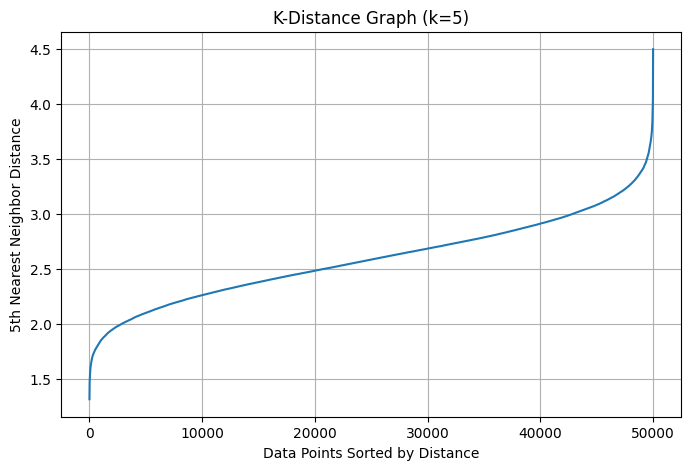

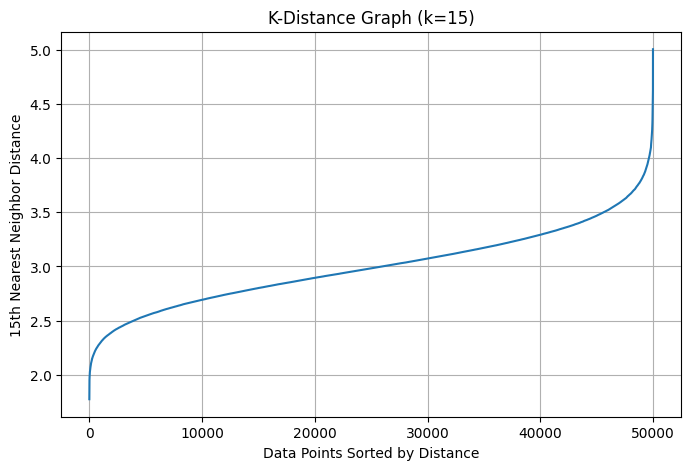

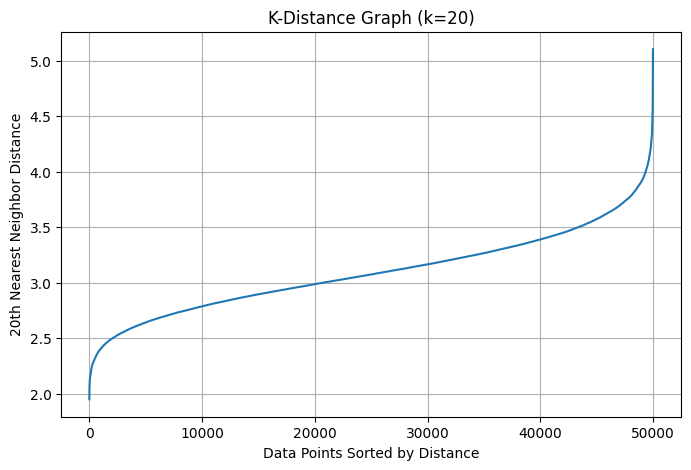

In [201]:

for k in [5, 15, 20]:
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    k_distances = np.sort(distances[:, k-1])
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_distances)
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Data Points Sorted by Distance")
    plt.ylabel(f"{k}th Nearest Neighbor Distance")
    plt.grid(True)
    plt.show()

In [202]:
from sklearn.cluster import DBSCAN

# I tried to stay around the "elbow" point and this min_samples gave me the best result 
# (Believe me, I tried many other values, to make it better)
dbscan = DBSCAN(eps=3, min_samples= 32)  
labels = dbscan.fit_predict(X_scaled)

df['cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Clusters count: {n_clusters}")
print(f"Noise: {n_noise}")
print(df['cluster'].value_counts())


Clusters count: 11
Noise: 17134
cluster
-1     17134
 1     12225
 2      5618
 0      3203
 6      3162
 4      3098
 5      1858
 3      1823
 7       652
 9       606
 8       589
 10       32
Name: count, dtype: int64


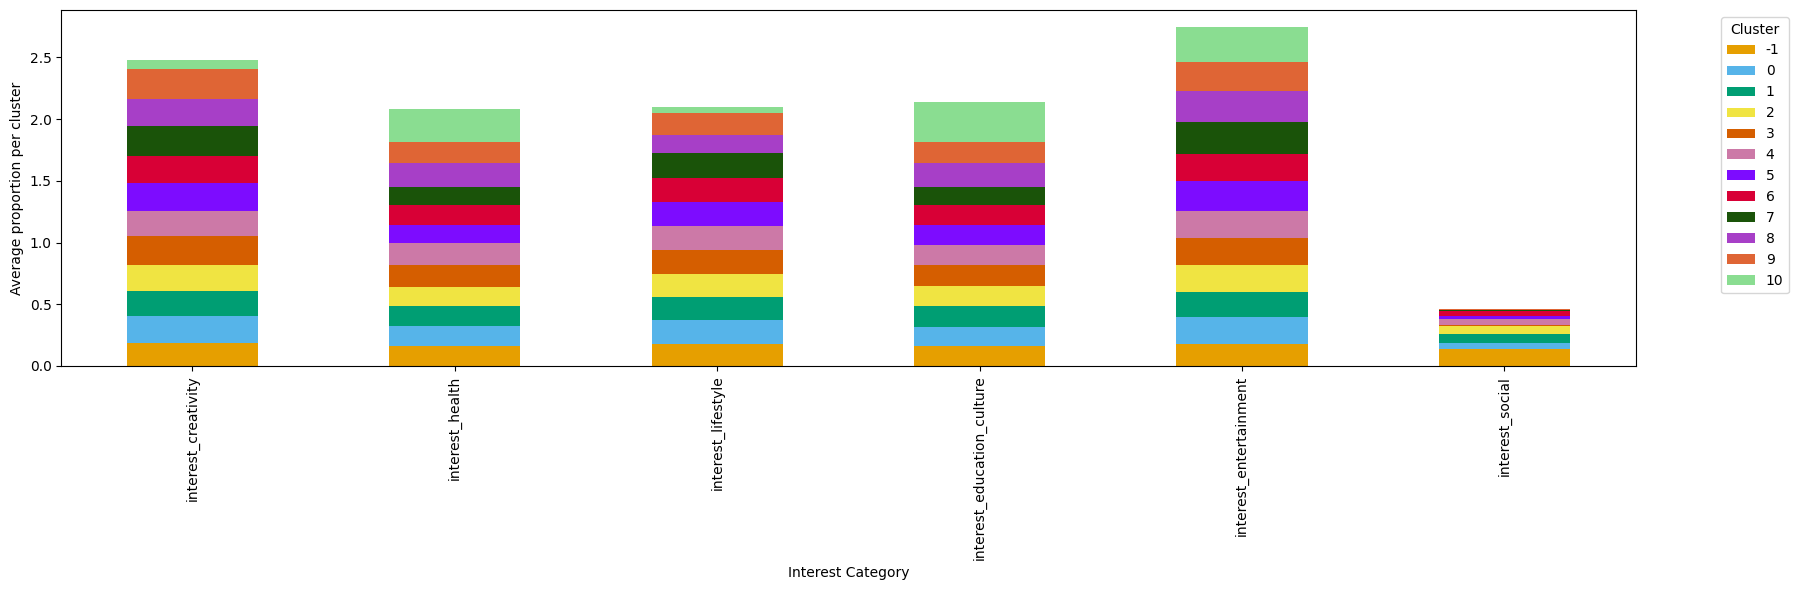

In [205]:
interest_cols = ['interest_creativity',	'interest_health',	'interest_lifestyle',	'interest_education_culture',
                    'interest_entertainment', 'interest_social']

interest_per_cluster = df.groupby('cluster')[interest_cols].mean()
percent = interest_per_cluster.T

percent.plot(kind='bar', stacked=True, figsize=(18, 6), color=colors)
plt.ylabel('Average proportion per cluster')
plt.xlabel('Interest Category')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [206]:
from sklearn.metrics import silhouette_score

noise = labels != -1
score = silhouette_score(X[noise], labels[noise])
print(f'Silhouette Score: {score:.3f}')

Silhouette Score: -0.027


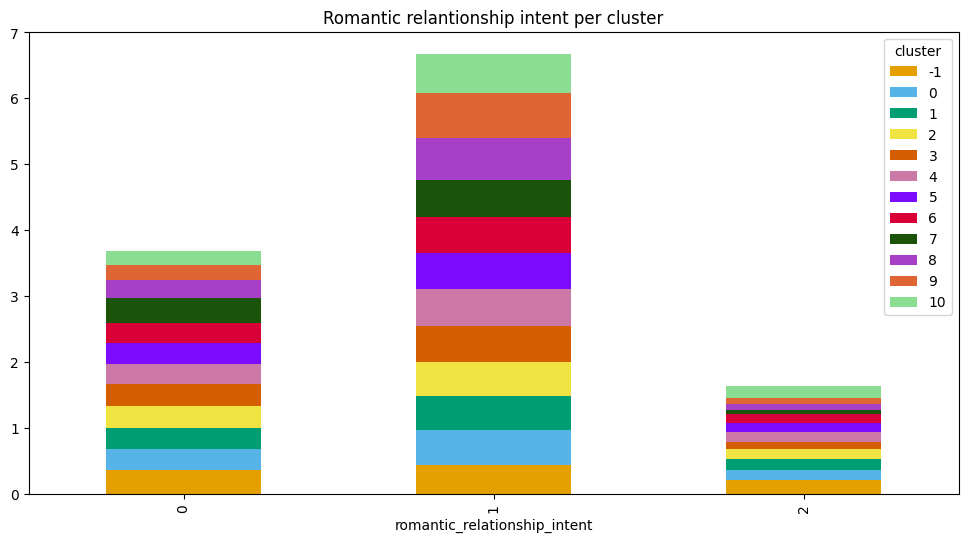

In [207]:
df['romantic_relationship_intent'] = df['romantic_relationship_intent'].astype(str)
pd.crosstab(df['cluster'], df['romantic_relationship_intent'], normalize='index').T.plot(
    kind='bar', stacked=True, figsize=(12,6), color=colors
)
plt.title("Romantic relantionship intent per cluster")
plt.show()

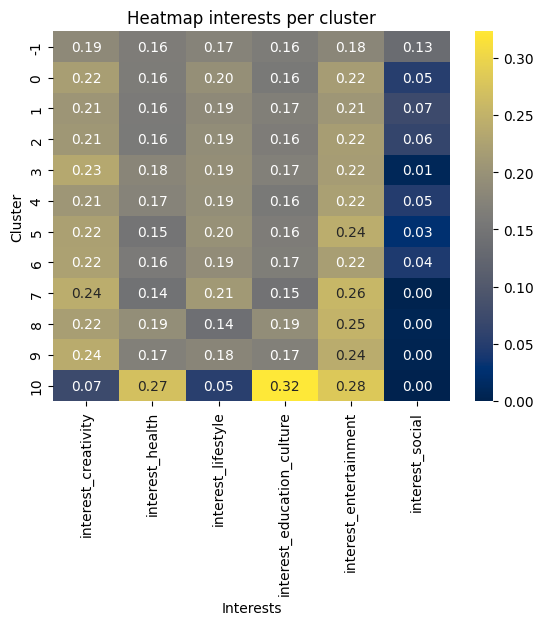

In [208]:
import seaborn as sns
clusters = df.groupby('cluster')[interest_cols].mean()
sns.heatmap(clusters, cmap='cividis', annot=True, fmt=".2f")
plt.title('Heatmap interests per cluster')
plt.ylabel('Cluster')
plt.xlabel('Interests')
plt.show()

<b>Clustering with DBSCAN</b></br>
For the final clustering method, I applied DBSCAN, using Nearest Neighbors to tune the hyperparameters. This approach turned out to be quite challenging. The algorithm consistently labeled over 70% of the data as noise. After extensive experimentation, the best result came with eps=3 and min_samples=32.

With those parameters, DBSCAN found 11 clusters, and the noise dropped to 34% of the dataset. The largest cluster contains about 24% of the data, while the smallest cluster holds just 0.06%. This shows a strong imbalance in cluster sizes, especially compared to KMeans, where clusters were much more evenly distributed — which is expected, since KMeans tries to minimize distances and favors symmetry.

When examining the interest features, the clusters appear very homogeneous, with no clear standout values. The same applies to relationship intentions, which again show no meaningful distinctions between clusters.

The Silhouette Score was -0.027, which indicates that this was not a good clustering.

In this case, DBSCAN was not a good fit for the dataset.